In [2]:
%load_ext autoreload
%autoreload 2

import random
import ray
import pandas
from typing import Dict, List, Tuple, Set
from mobile import PROJECT_ROOT
from mobile.utils import *
from mobile.heuristics import *
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### Frequent Cover Locations ###

In [3]:
import tqdm
import time
def radius_nbrs(radius: int):
    start = time.time()
    
    neighbors = {}
    
    LOCATIONS_act = [l for l in range(len(LOCATIONS)) if not LOCATIONS[l]['home']]
    
    for l in tqdm.tqdm(LOCATIONS_act):
        dist_nbrs = set()
        
        for j in range(len(LOCATIONS)):
            dist = calculate_distance(l, j)
            if dist < radius:
                dist_nbrs = dist_nbrs.union(LOCATIONS[j]["pid"])
            
        neighbors[l] = dist_nbrs
    
    end = time.time()
    print(end-start)
    
    return neighbors


In [4]:
def cover_most_radius(r: int, k: int):
    """
    Helper method for FPT: returns the set of activity locations of size s that cover the most clients
    Used with aggregate activity locations
    
    aggregation : int
    the version of aggregation selected
    0 --> none
    1 --> set cover: aggregation with repeats in coverage
    """
    
    neighbors = radius_nbrs(r)
    
    covered = set()
    selected = []
    for i in range(k):
        most_coverage = max([(len(neighbors[l] - covered), l, neighbors[l]) for l in neighbors.keys()])
        selected.append(most_coverage[1])
        covered = covered.union(LOCATIONS[most_coverage[1]]['pid'])
    print(f"COVERAGE OF CLIENTS BY {s} LOCATIONS: ", len(covered)/len(CLIENT_LOCATIONS.keys()))
    return selected


In [5]:
fac = cover_most_radius(0, 5)

100%|██████████| 6176/6176 [14:42<00:00,  7.00it/s]


882.7717835903168


NameError: name 's' is not defined

In [5]:
from mobile.config import LOCATIONS, CLIENT_LOCATIONS

In [7]:
check = [17177, 4, 139, 95, 714, 76, 44, 504, 976, 313, 6, 270, 8, 1, 212, 142, 393, 160, 1149, 204, 15, 219, 80, 525]

for c in check:
    print(c, LOCATIONS[c]['latitude'])

print(len(LOCATIONS))

IndexError: list index out of range

In [ ]:
set_cover_aggregation(LOCATIONS, CLIENT_LOCATIONS, county_name: str = 'charlottesville_city', radius: float = 0.01):

In [5]:
import ray

ray.init(ignore_reinit_error=True)

@ray.remote
def process(j):
    return calculate_distance(1, j)

start = time.time()
sorted_distance_neighbors = [process.remote(j) for j in range(len(LOCATIONS))]
results = ray.get(sorted_distance_neighbors)
end = time.time()
print(end-start)

2021-09-04 21:33:16,674	INFO worker.py:810 -- Calling ray.init() again after it has already been called.


2.258667230606079


In [8]:
start = time.time()
sorted_distance_neighbors = [calculate_distance(1, j) for j in range(len(LOCATIONS))]
end = time.time()
print(end-start)

0.17068767547607422


In [1]:
print(len([0, 515, 4, 517, 5, 7, 8, 12822, 22, 406, 158, 32, 7714, 420, 804, 431, 52, 55, 440, 571, 70, 206, 591, 1358, 81, 3411, 2517, 1367, 3423, 485, 103, 367, 16756, 500, 374, 759, 7802, 507, 16767]))

39


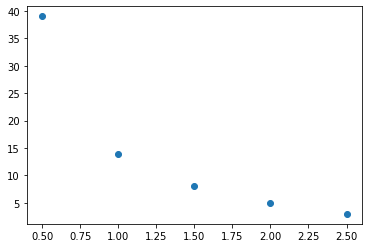

In [4]:
plt.scatter([i/10 for i in range(5,26,5)], [39,14,8,5,3])

### FPT (with added combinatorial) ###

* Find lowerbound for k
* Iterate through k for nCk guesses until a hitting set is obtained
* Iterate through all combinations for that given k to hitting set with smallest objective value

In [10]:
def is_hitting_set(guess, client_locations):
    
    covered_clients = set()
    
    for g in guess:
        covered_clients = covered_clients.union(LOCATIONS[g]['pid'])
    
    return len(covered_clients) == len(client_locations)

In [3]:
from itertools import combinations

In [5]:
from mobile.config import LOCATIONS, CLIENT_LOCATIONS

In [1]:
def generate_guesses(visited_locations, client_locations):
    
    #Find lowerbound for k
    #Find large set of non-intersecting S_j
    
    clients = set(client_locations.keys())
    intersection = set({})
    visited_covered = set({})
    while len(clients)!=0:
        node = clients.pop()
        if len(visited_covered.intersection((client_locations[node]))) == 0:
            intersection.add(node)
            visited_covered = visited_covered.union(client_locations[node])
    
    k = len(intersection)
    print(k)
    
    #Find smallest k to get a hitting set
    hitting_set_found = False
    
    while not hitting_set_found and k <= len(visited_locations):
        
        guess_combinations = list(combinations(visited_locations, k))
                
        for guess in guess_combinations:
            hitting_set_found = is_hitting_set(guess, client_locations)
            
            if hitting_set_found:
                print(k, len(guess_combinations))
                return guess_combinations
        
        k+=1
    
    return [-1]

In [25]:
def fpt_combinatorial(k: int, s: int):
    """
    Picks the s activity locations that cover the most clients (through a set cover approximation)
    Assumes the number of locations visited by clients is bounded by a constant
    Run k-supplier on all combination sets of locations that will be covered by facilities. Select the guess and its open facilities with the smallest objective value.
    
    PARAMETERS
    ----------
    k : int
        number of facilities to be opened
    s : int
        number of activity locations examined
    aggregation : int
        the version of aggregation selected
        0 --> none
        1 --> set cover: aggregation without repeats in coverage
        2 --> set cover: aggregation with repeats in coverage
        
    RETURNS
    ----------
    facilities : List[int]
        contains facility indices that are open
    assignments : List[Tuple[int, int]]
        visited location and facility assignment indexed by each client
    """
    
    potential_facility_locations = cover_most(s)
    
    #Remove homes from the client_location lists
    #TODO: Perhaps create mapping for the indices of people before exclusion and after?
    client_locations_dict = {}
    client_locations_excluded = []
    for key, person in CLIENT_LOCATIONS.items():
        new_list = [p for p in person[1:] if p in potential_facility_locations]
        if len(new_list)>0:
            client_locations_excluded.append(new_list)
            client_locations_dict[key] = new_list
    
    locations = [LOCATIONS[i]['lid_ind'] for i in range(len(LOCATIONS)) if not LOCATIONS[i]['home']]
    
    G, loc_map, c_loc_map = precompute_distances(client_locations_excluded, locations)
    
    ray.init(ignore_reinit_error=True)
    
    @ray.remote
    def process(guess):
        facilities = k_supplier(list(guess), locations, k)
        obj_value = assign_client_facilities(G, loc_map, c_loc_map, client_locations_excluded, facilities)
        return obj_value, facilities
    
    futures = [process.remote(guess) for guess in generate_guesses(list(potential_facility_locations), client_locations_dict)]
    results = ray.get(futures)

    min_obj_guess: Tuple[int, List[int]] = min(results)
    return min_obj_guess, assign_facilities(min_obj_guess[1])

In [27]:
fac, assgn = fpt_combinatorial(5, 20)

COVERAGE OF CLIENTS BY 20 LOCATIONS:  0.8479008324285198


2021-08-29 10:52:42,257	INFO worker.py:810 -- Calling ray.init() again after it has already been called.


13
1


In [22]:
print(fac)

(1.4578742022763782, [0, 1, 5, 9, 46])


In [23]:
print(calculate_objective(assgn))

2.3956977875908194


### Set Cover ###

In [2]:
import time
import tqdm.notebook as tqdm

def generate_sorted_neighbors_list(radius: float):

    start = time.time()

    neighbors = {}

    LOCATIONS_act = [l for l in range(len(LOCATIONS)) if not LOCATIONS[l]['home']]

    for l in tqdm.tqdm(LOCATIONS_act):
        
        neighbors[l] = set({})

        for j in range(len(LOCATIONS)):
            dist = calculate_distance(l, j)
            if dist <= radius:
                neighbors[l].add(j)

    end = time.time()

    print(end-start)
    
    print(neighbors[0])
    
    return neighbors

In [10]:
import json
neighbors = {5:[(1, [2,3,4]), (2, [2, 3, 6])]}

with open(PROJECT_ROOT/ 'data'/ 'processed'/ 'charlottesville_city' / f'sorted_neighbors_list.json', 'w') as f:
    data = {"neighbors": {key: (value[0], list(value[1])) for key,value in neighbors.items()}}
    json.dump(data, f)

In [3]:
def set_cover(radius: float):
    
    neighbors = generate_sorted_neighbors_list(radius)
    
    covered = set()
    chosen = set()
    
    while len(covered) != len(CLIENT_LOCATIONS):
        
        max_coverage = (0, -1, set())
        
        for loc in radius_dict.keys():
            
            if loc not in chosen:
            
                radius_dict[loc] = radius_dict[loc] - covered

                individuals_covered = radius_dict[loc]

                if len(individuals_covered) > max_coverage[0]:
                    max_coverage = (len(individuals_covered), loc, individuals_covered)
        
        if max_coverage[0] == 0:
            break
        
        covered = covered.union(max_coverage[2])
        chosen.add(max_coverage[1])
        print(len(covered))
    
    return chosen

In [4]:
from mobile.config import LOCATIONS, CLIENT_LOCATIONS

In [ ]:
k = set_cover(3)

In [9]:
def set_cover_experiment():
    
    neighbors = generate_sorted_neighbors_list_2()

    for radius in range(5, 50, 5):
        
        fac = set_cover_2(radius/10, neighbors)
        
        print(radius/10, len(fac))

In [7]:
import time
import tqdm.notebook as tqdm

def generate_sorted_neighbors_list_2():

    start = time.time()

    neighbors = {}

    LOCATIONS_act = [l for l in range(len(LOCATIONS)) if not LOCATIONS[l]['home']]

    for l in tqdm.tqdm(LOCATIONS_act[:1]):
        sorted_distance_neighbors = []

        for j in range(len(LOCATIONS)):
            dist = calculate_distance(l, j)
            sorted_distance_neighbors.append((dist, j))

        sorted_distance_neighbors = sorted(sorted_distance_neighbors, reverse = False)
        
        neighbors[l] = []
        for ind, loc in enumerate(sorted_distance_neighbors):
            dist = loc[0]
            ngbr = loc[1]
            if ind == 0:
                neighbors[l].append((dist, set(LOCATIONS[ngbr]['pid'])))
            else:
                last_set = neighbors[l][-1][1]
                new_client_union = last_set.union(set(LOCATIONS[ngbr]['pid']))
                neighbors[l].append((dist, new_client_union))
            
            print(neighbors[l][-1])
        
    end = time.time()

    print(end-start)
    
    return neighbors

In [21]:
def set_cover_2(radius: float, neighbors):
    
    radius_dict = {}
    
    for l, neighbor in tqdm.tqdm(neighbors.items()):

        left = 0
        right = len(neighbor)
        index_cutoff = 0
        while left <= right:
            mid = left+(right-left)//2
            if neighbor[mid][0] <= radius:
                left = mid
                index_cutoff = mid
            else:
                right = mid
        
        radius_dict[l] = neighbor[index_cutoff][1]
    
    print(len(radius_dict))
    
    covered = set()
    chosen = set()
    
    while len(covered) != len(CLIENT_LOCATIONS):
        
        max_coverage = (0, -1, set())
        
        for loc in radius_dict.keys():
            
            if loc not in chosen:
            
                radius_dict[loc] = radius_dict[loc] - covered

                individuals_covered = radius_dict[loc]

                if len(individuals_covered) > max_coverage[0]:
                    max_coverage = (len(individuals_covered), loc, individuals_covered)
        
        if max_coverage[0] == 0:
            break
        
        covered = covered.union(max_coverage[2])
        chosen.add(max_coverage[1])
    
    return chosen

In [24]:
neighbors = {5: [(1, {1,2,3}), (500, {2})], 10: [(100, {2, 4, 7})]}

In [28]:
radius_dict = {}
radius = 0.1

for l, neighbor in tqdm.tqdm(neighbors.items()):

    left = 0
    right = len(neighbor)-1
    index_cutoff = 0
    
    while left <= right:
        
        mid = left+(right-left)//2

        if neighbor[mid][0] <= 50:
            left = mid + 1
            index_cutoff = mid
        else:
            right = mid - 1
    
    print(index_cutoff, neighbor[index_cutoff][0])
    radius_dict[l] = neighbor[index_cutoff][1]

  0%|          | 0/2 [00:00<?, ?it/s]

0 1
0 100


In [ ]:
fac = set_cover_2(radius/10, neighbors)

In [ ]:
def set_cover_2(neighbors, radius: float, prev_radius: float, prev_radius_dict):
    
    radius_dict = {"pid": set(), "index": -1}
    
    for l, neighbor in tqdm.notebook.tqdm(neighbors.items()):
        
        radius_dict[l] = set()
        
        if prev_radius < radius:
            
            for ind in range(prev_radius_dict[l]['index']):
                n = neighbor[ind]
                if n[0] <= radius:                
                    ngbr = n[1]
                    radius_dict[l]['pid'] = radius_dict[l].union(LOCATIONS[ngbr]['pid'])
                    radius_dict[l]['index'] = ind
                else:
                    break
            
        else:
            
            radius_dict[l]['pid'] = prev_radius_dict[l]['pid']
            radius_dict[l]['index'] = prev_radius_dict[l]['index']
            
            for ind in range(prev_radius_dict[l]['index'], len(neighbor)):
                
                n = neighbor[ind]
                if n[0] <= radius:                
                    ngbr = n[1]
                    radius_dict[l]['pid'] = radius_dict[l].union(LOCATIONS[ngbr]['pid'])
                    radius_dict[l]['index'] = ind
                else:
                    break
    
    #print(len(radius_dict))
    
    covered = set()
    chosen = set()
    
    while len(covered) != len(CLIENT_LOCATIONS):
        
        max_coverage = (0, -1, set())
        
        for pair in radius_dict.keys():
            
            loc = pair['pid']
            
            if loc not in chosen:
            
                radius_dict[loc]['pid'] = radius_dict[loc]['pid'] - covered

                individuals_covered = radius_dict[loc]['pid']

                if len(individuals_covered) > max_coverage[0]:
                    max_coverage = (len(individuals_covered), loc, individuals_covered)
        
        if max_coverage[0] == 0:
            break
        
        covered = covered.union(max_coverage[2])
        chosen.add(max_coverage[1])
        
        #print(len(covered))
    
    return chosen, radius_dict

### Set Cover Alg ###

In [16]:
def cover_approx(neighbors, k: int):
    
    l = 1.5
    h = 2.5
    
    facilities = []
    objective = 10005
    
    #alpha = 0
    
    #for i in range(1, len(CLIENT_LOCATIONS)+1):
    #    alpha += 1/i
    
    #print(alpha)
    
    alpha = 1
    
    #caclulate neighbors
    
    while h-l > 1e-6:
        r = (l+h)/2
        
        print(r)
        
        sol = set_cover(neighbors, radius = r)
        
        if len(sol) <= alpha * k:
            h = (l+h)/2
            facilities = sol
            objective = r
        else:
            l = (l+h)/2
            
        print(r, len(sol))
        
    return facilities, objective

In [23]:
from mobile import PROJECT_ROOT
import json
import tqdm

with open(PROJECT_ROOT/ 'output'/ 'runs'/ 'charlottesville_city' / f'neighbors.json', 'r') as f:
    data = json.load(f)
    neighbors = data['neighbors']
    print(len(neighbors))

9165


In [31]:
total = [len(set_cover_softmax(neighbors, 0.1, 20)) for i in range(50)]
print(sum(total)/len(total))
#for i in range(10):
#    covered = set_cover(neighbors, 0.1)

<ipython-input-25-95f420ee73da>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):


  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

  0%|          | 0/9165 [00:00<?, ?it/s]

157.54


<ipython-input-31-509bebdd4f8e>:2: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  print(sum(total)/len(total))


In [32]:
print(min(total))

153


In [21]:
print(total)

[159, 164, 156, 160, 156, 154, 162, 158, 166, 165]


In [30]:
print(min(total))

155


In [26]:
import numpy as np
from scipy import special
print(len(set_cover_softmax(neighbors, 0.1, 1)))

<ipython-input-25-95f420ee73da>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):


  0%|          | 0/9165 [00:00<?, ?it/s]

156


In [13]:
import time
import tqdm

start = time.time()

neighbors = {}

LOCATIONS_act = [l for l in range(len(LOCATIONS)) if not LOCATIONS[l]['home']]

for l in tqdm.tqdm_notebook(LOCATIONS_act):
    neighbors[l] = sorted([(calculate_distance(l, j),j) for j in range(len(LOCATIONS))], reverse= False)

end = time.time()

print(end-start)

<ipython-input-13-0c8be39f6e2e>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l in tqdm.tqdm_notebook(LOCATIONS_act):


  0%|          | 0/9165 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [14]:
import time
import tqdm

start = time.time()

neighbors = {}

LOCATIONS_act = [l for l in range(len(LOCATIONS)) if not LOCATIONS[l]['home']]

for l in tqdm.tqdm_notebook(LOCATIONS_act):
    sorted_distance_neighbors = []
    #sorted_distance_neighbors = sorted([(calculate_distance(l, j),j) for j in range(len(LOCATIONS))], reverse= False)
    
    for j in range(len(LOCATIONS)):
        dist = calculate_distance(l, j)
        sorted_distance_neighbors.append((dist, j))
        
    sorted_distance_neighbors = sorted(sorted_distance_neighbors, reverse = False)
    neighbors[l] = sorted_distance_neighbors

end = time.time()

print(end-start)

<ipython-input-14-fd78dd18019a>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for l in tqdm.tqdm_notebook(LOCATIONS_act):


  0%|          | 0/9165 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
def set_cover(neighbors, radius: float, top: int):
    
    radius_dict = {}
    
    for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):
        
        radius_dict[l] = set()
        
        for n in neighbor:
            
            if n[0] <= radius:                
                ngbr = n[1]
                radius_dict[l] = radius_dict[l].union(LOCATIONS[ngbr]['pid'])
            else:
                break
    
    #print(len(radius_dict))
    
    covered = set()
    chosen = set()
    
    while len(covered) != len(CLIENT_LOCATIONS):
        
        max_coverage = []
        
        for loc in radius_dict.keys():
            
            if loc not in chosen:
            
                radius_dict[loc] = radius_dict[loc] - covered

                individuals_covered = radius_dict[loc]
                max_coverage.append((len(individuals_covered), loc, individuals_covered))
        
        max_coverage = sorted(max_coverage, reverse = True)
        
        if max_coverage[0][0] == 0:
            break
        
        chosen_max = max_coverage[random.randint(0, top)]
        
        covered = covered.union(chosen_max[2])
        chosen.add(chosen_max[1])
        
        #print(len(covered))
    
    return chosen

In [25]:
#George Li
def set_cover_softmax(neighbors, radius: float, top: int):
    
    radius_dict = {}
    
    for l, neighbor in tqdm.tqdm_notebook(neighbors.items()):
        
        radius_dict[l] = set()
        
        for n in neighbor:
            
            if n[0] <= radius:                
                ngbr = n[1]
                radius_dict[l] = radius_dict[l].union(LOCATIONS[ngbr]['pid'])
            else:
                break
    
    #print(len(radius_dict))
    
    covered = set()
    chosen = set()
    
    while len(covered) != len(CLIENT_LOCATIONS):
        
        max_coverage = []
        
        for loc in radius_dict.keys():
            
            if loc not in chosen:
            
                radius_dict[loc] = radius_dict[loc] - covered

                individuals_covered = radius_dict[loc]
                max_coverage.append((len(individuals_covered), loc, individuals_covered))
        
        max_coverage = sorted(max_coverage, reverse = True)
        
        if max_coverage[0][0] == 0:
            break
        
        a = [i for i in range(top)]
        p = np.array([max_coverage[i][0] for i in range(top)])
        p = 10*p/p.max()
        p = scipy.special.softmax(p)  
        choice = max_coverage[np.random.choice(a=a, p=p)]
        
        covered = covered.union(choice[2])
        chosen.add(choice[1])
        
        #print(len(covered))
    
    return chosen

In [ ]:
def set_cover_2(neighbors, radius: float, prev_radius: float, prev_radius_dict):
    
    radius_dict = {"pid": set(), "index": -1}
    
    for l, neighbor in tqdm.notebook.tqdm(neighbors.items()):
        
        radius_dict[l] = set()
        
        if prev_radius < radius:
            
            for ind in range(prev_radius_dict[l]['index']):
                n = neighbor[ind]
                if n[0] <= radius:                
                    ngbr = n[1]
                    radius_dict[l]['pid'] = radius_dict[l].union(LOCATIONS[ngbr]['pid'])
                    radius_dict[l]['index'] = ind
                else:
                    break
            
        else:
            
            radius_dict[l]['pid'] = prev_radius_dict[l]['pid']
            radius_dict[l]['index'] = prev_radius_dict[l]['index']
            
            for ind in range(prev_radius_dict[l]['index'], len(neighbor)):
                
                n = neighbor[ind]
                if n[0] <= radius:                
                    ngbr = n[1]
                    radius_dict[l]['pid'] = radius_dict[l].union(LOCATIONS[ngbr]['pid'])
                    radius_dict[l]['index'] = ind
                else:
                    break
    
    #print(len(radius_dict))
    
    covered = set()
    chosen = set()
    
    while len(covered) != len(CLIENT_LOCATIONS):
        
        max_coverage = (0, -1, set())
        
        for pair in radius_dict.keys():
            
            loc = pair['pid']
            
            if loc not in chosen:
            
                radius_dict[loc]['pid'] = radius_dict[loc]['pid'] - covered

                individuals_covered = radius_dict[loc]['pid']

                if len(individuals_covered) > max_coverage[0]:
                    max_coverage = (len(individuals_covered), loc, individuals_covered)
        
        if max_coverage[0] == 0:
            break
        
        covered = covered.union(max_coverage[2])
        chosen.add(max_coverage[1])
        
        #print(len(covered))
    
    return chosen, radius_dict

In [ ]:
def cover_approx_2(neighbors, k: int):
    
    l = .2
    h = .5
    
    facilities = []
    objective = 10005
    
    alpha = 0
    
    for i in range(1, len(CLIENT_LOCATIONS)+1):
        alpha += 1/i
    
    print(alpha)
    
    prev_rad_dict = {l:{"pid": set(), "index": -1} for l in LOCATIONS_act}
    prev_radius = -1
    
    #caclulate neighbors
    
    while h-l > 1e-6:
        r = (l+h)/2
        
        print(r)
        
        sol, prev_rad_dict = set_cover_2(neighbors, r, prev_radius, prev_rad_dict)
        prev_radius = r
        
        if len(sol) <= alpha * k:
            h = (l+h)/2
            facilities = sol
            objective = r
        else:
            l = (l+h)/2
            
        print(r, len(sol))
        
    return facilities, objective

In [ ]:
facilities, objective = cover_approx_2(neighbors, 5)

### Set Cover (initial attempt) ###

In [ ]:
def set_cover_search():
    
    radius_options = []
    #all possible client locations
    for i in range(len(LOCATIONS)):
        
        #all possible facility locations
        for j in range(i, len(LOCATIONS)):
            if not LOCATIONS[j]['home']:
                
                radius_options.append(calculate_distance(i,j))
    
    print("filled")
    
    radius_options = sorted(radius_options)
    
    print(radius_options[:10])

In [ ]:
import numpy as np
from sklearn.neighbors import BallTree
from networkx.utils.union_find import UnionFind

In [ ]:
def client_cover(r: float):
    #Ball Tree coverage
    print(r)
    
    THRESHOLD = r # distance in km
    EARTH_RADIUS = geopy.distance.EARTH_RADIUS # kilometers
    THRESHOLD_R = THRESHOLD / EARTH_RADIUS

    loc_tuple = [(np.radians(LOCATIONS[i]['latitude']), np.radians(LOCATIONS[i]['longitude'])) for i in range(len(LOCATIONS)) if not LOCATIONS[i]['home']]
    loc_index = [i for i in range(len(LOCATIONS)) if not LOCATIONS[i]['home']]

    print(len(loc_index))
    
    tree = BallTree(loc_tuple, leaf_size=40, metric='haversine')
    
    groups = tree.query_radius(loc_tuple, r=THRESHOLD_R)
    groups = [[loc_index[i] for i in g] for g in groups]
    groups = list(groups) + [[i,i] for i in range(len(LOCATIONS)) if LOCATIONS[i]['home']]
    
    print(len(groups))
    
    start = time.time()
    radius_dict = {}
    
    for i in range(len(LOCATIONS)):
        radius_dict[i] = []
        for g in groups:
            if i in g:
                radius_dict[i] += g
        if i%1000 == 0:
            print(i)
    
    print(time.time() - start)
    
    '''count = 0
    for group in groups:
        for loc in group:
            if loc in radius_dict.keys():
                radius_dict[loc] += group
            else:
                radius_dict[loc] = group
        print(count, group)
        count+=1'''
    
    print(len(radius_dict))
    
    start = time.time()
    cover = set()
    chosen = set()

    while len(cover) < len(CLIENT_LOCATIONS):
        max_choice = (0, set(), -1)

        for key, val in radius_dict.items():
            print(key)
            
            clients_covered = set()
            for v in val:
                clients_covered = clients_covered.union(LOCATIONS[v]['pid'])
            
            clients_covered = clients_covered-cover
            
            print(len(clients_covered))
            
            if len(clients_covered)>max_choice[0]:
                max_choice = (len(clients_covered), clients_covered, key)
        
        cover = cover.union(max_choice[1])
        chosen.add(max_choice[2])
        print(len(chosen), len(chosen))
    print(time.time() - start)
    return chosen

In [ ]:
def set_cover_search(k: int):
    
    alpha = math.log(len(CLIENT_LOCATIONS))+1
    
    l = 0
    r = 10
    to_ret = -1
    EPSILON = 10**(-4)
    
    while r-l > EPSILON:
    
        mid = l + (r - l) / 2

        print(mid)
        
        cover = client_cover(mid)
        
        if len(cover) <= alpha * k:
            r = mid
            to_ret = mid
        else:
            l = mid
        
        print(mid, len(cover))
    
    return to_ret, client_cover(to_ret)

In [ ]:
import math
import geopy
import numpy as np
from mobile.config import LOCATIONS, CLIENT_LOCATIONS